### Hypothesis: the ratio of 'time since posting' to 'percent of goal completed' has to be close to or below 1/1 in order to attract donations
#### possibility: donation probability may be best when the ratio is close to 1/1 than at <<1/1

In [1]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import matplotlib.patches as patch
from matplotlib import gridspec
from datetime import datetime, timedelta
from tqdm import tqdm

In [2]:
plt.style.use('seaborn-white')
plt.close('all')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
size_mult = 1

### Load relevant DonorsChoose data

In [3]:
projects_df = pd.read_csv('Projects.csv')
donations_df = pd.read_csv('Donations.csv')

In [4]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110017 entries, 0 to 1110016
Data columns (total 18 columns):
Project ID                          1110017 non-null object
School ID                           1110017 non-null object
Teacher ID                          1110017 non-null object
Teacher Project Posted Sequence     1110017 non-null int64
Project Type                        1110017 non-null object
Project Title                       1110011 non-null object
Project Essay                       1110016 non-null object
Project Short Description           1110014 non-null object
Project Need Statement              1110014 non-null object
Project Subject Category Tree       1109988 non-null object
Project Subject Subcategory Tree    1109988 non-null object
Project Grade Level Category        1110017 non-null object
Project Resource Category           1109981 non-null object
Project Cost                        1110017 non-null float64
Project Posted Date                 1110017 non

In [5]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110017 entries, 0 to 1110016
Data columns (total 18 columns):
Project ID                          1110017 non-null object
School ID                           1110017 non-null object
Teacher ID                          1110017 non-null object
Teacher Project Posted Sequence     1110017 non-null int64
Project Type                        1110017 non-null object
Project Title                       1110011 non-null object
Project Essay                       1110016 non-null object
Project Short Description           1110014 non-null object
Project Need Statement              1110014 non-null object
Project Subject Category Tree       1109988 non-null object
Project Subject Subcategory Tree    1109988 non-null object
Project Grade Level Category        1110017 non-null object
Project Resource Category           1109981 non-null object
Project Cost                        1110017 non-null float64
Project Posted Date                 1110017 non

In [6]:
display(projects_df.head(3))
display(donations_df.head(12))

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22


,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38
5,000009891526c0ade7180f8423792063,8cea27f0cc03f41f66aab96b284ae6a1,896c75c9b8d9a91c759746e566cd3f37,Yes,15.00,1,2016-06-04 17:58:55
6,00000ce845c00cbf0686c992fc369df4,39af862cb04e4f938e5b827236a610a6,8a1875762c85932fff192ea126ccdff2,Yes,50.00,1,2013-02-27 09:07:51
7,00000ce845c00cbf0686c992fc369df4,c47f78571f62bcf10eee6a46a4a8a85d,a3f070e439d52de72ca62dc41f9b16a4,Yes,50.00,2,2013-02-27 09:53:12
8,00000ce845c00cbf0686c992fc369df4,19351e1d9ae0bccab31b1f6009ad47a3,bd323208dc78b1c74b62664b768f3176,Yes,200.00,2,2013-02-17 21:36:24
9,00000ce845c00cbf0686c992fc369df4,d5364b1bb3b14594808bd6efa7544165,6dd6113f89f2766d3b0707ef2a46260c,Yes,10.00,44,2013-02-27 10:32:22


### Subset data to only include projects that have been fully funded or expired
##### Projects expire 4 months after posting if not fully funded. Fill in these dates for expired projects

In [7]:
finished_projects_df = projects_df[projects_df['Project Current Status'].str.contains('Fully Funded|Expired')].copy()

###convert date columns to datetime
rel_date_cols = ['Project Posted Date', 'Project Fully Funded Date', 'Project Expiration Date']
finished_projects_df[rel_date_cols] = finished_projects_df[rel_date_cols].apply(pd.to_datetime)

#### a few 'Project Expiration Date' are empty - fill in with 'Project posted date' + 4 months
nulls = finished_projects_df['Project Expiration Date'].isnull()
finished_projects_df.loc[nulls, 'Project Expiration Date'] = finished_projects_df.loc[nulls, 'Project Posted Date'] + pd.DateOffset(months = 4)

### fill in 'project end date' for projects that expired with 'Project expiration date'
expired = finished_projects_df['Project Fully Funded Date'].isnull()
finished_projects_df.loc[expired, 'Project Fully Funded Date'] = finished_projects_df.loc[expired, 'Project Expiration Date']
finished_projects_df = finished_projects_df.rename(columns = {'Project Fully Funded Date':'Project End'})

### certain projects did not have a valid expiration date - fill those in with posting date + 4 months
nulls = finished_projects_df['Project End'].isnull()
finished_projects_df.loc[nulls, 'Project End'] = finished_projects_df.loc[nulls, 'Project Posted Date'] + pd.DateOffset(months = 4)
finished_projects_df['Days Open'] = ((finished_projects_df['Project End'] - finished_projects_df['Project Posted Date'])/ np.timedelta64(1, 'D')).astype(int)

### remove projects that have expiration dates that precede posting date (data entry error?)
finished_projects_df = finished_projects_df[finished_projects_df['Days Open']>0]

finished_projects_df= finished_projects_df.reset_index(drop = True)


In [8]:
# finished_projects_df = finished_projects_df[100000:200000] #subset for faster prototyping

### Need to restructure data such that each row represents one donation for a given project

In [9]:
proj_don_df = donations_df[['Project ID', 'Donation Received Date', 'Donation Amount']
                             ].merge(finished_projects_df[['Project ID']], how = 'inner', on = ['Project ID'])
proj_don_df['Donation Received Date'] = pd.to_datetime(pd.to_datetime(proj_don_df['Donation Received Date']).dt.date)
proj_don_df.head()

,Project ID,Donation Received Date,Donation Amount
0,000009891526c0ade7180f8423792063,2016-08-23,178.37
1,000009891526c0ade7180f8423792063,2016-06-06,25.00
2,000009891526c0ade7180f8423792063,2016-06-06,20.00
3,000009891526c0ade7180f8423792063,2016-05-15,25.00
4,000009891526c0ade7180f8423792063,2016-05-17,25.00


In [10]:
proj_don_df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410411 entries, 0 to 4410410
Data columns (total 3 columns):
Project ID                4410411 non-null object
Donation Received Date    4410411 non-null datetime64[ns]
Donation Amount           4410411 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 134.6+ MB


#### Add back descriptive project features for each donation

In [11]:
proj_don_full = proj_don_df.merge(finished_projects_df[['Project ID', 'Project Posted Date', 'Project Cost','Project Current Status',
                                                          'Project End', 'Project Expiration Date', 'Days Open']], on = 'Project ID')
proj_don_full = proj_don_full.sort_values(['Project ID', 'Donation Received Date']).reset_index(drop = True)
proj_don_full.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410413 entries, 0 to 4410412
Data columns (total 9 columns):
Project ID                 4410413 non-null object
Donation Received Date     4410413 non-null datetime64[ns]
Donation Amount            4410413 non-null float64
Project Posted Date        4410413 non-null datetime64[ns]
Project Cost               4410413 non-null float64
Project Current Status     4410413 non-null object
Project End                4410413 non-null datetime64[ns]
Project Expiration Date    4410413 non-null datetime64[ns]
Days Open                  4410413 non-null int32
dtypes: datetime64[ns](4), float64(2), int32(1), object(2)
memory usage: 286.0+ MB


In [12]:
proj_don_full['Cum Donations'] = proj_don_full['Donation Amount'].fillna(0)
proj_groups = proj_don_full.groupby('Project ID')
proj_don_full['Cum Donations'] = proj_groups['Cum Donations'].cumsum()

#### Calculate features that donors may be using to decide whether to donate: 
* Days since posting/days until expiry
* Percent of asking price that has been donated

In [13]:
proj_don_full['Percent Completed'] = proj_don_full['Cum Donations']/proj_don_full['Project Cost']
proj_don_full['Percent Completed'] = proj_don_full['Percent Completed'].clip(upper = 1)

In [14]:
proj_don_full['Days Since Posting'] = proj_don_full['Donation Received Date'] - proj_don_full['Project Posted Date']
proj_don_full['Days Since Posting'] = pd.to_numeric(proj_don_full['Days Since Posting']/np.timedelta64(1, 'D'))
proj_don_full['Days Until Expiration'] = pd.to_datetime(proj_don_full['Project Expiration Date']) - proj_don_full['Donation Received Date']
proj_don_full['Days Until Expiration'] = pd.to_numeric(proj_don_full['Days Until Expiration']/np.timedelta64(1, 'D'))

### Although DonorsChoose projects are supposed to have a limit of 4 months, a small fraction of projects are allowed to stay active for longer
* This means that we should normalize 'days since posting' and 'days until expiration' to the total alotted time for each project in order to compare between
projects

In [15]:
finished_projects_df['Alloted Time'] = pd.to_numeric((finished_projects_df['Project Expiration Date'] - finished_projects_df['Project Posted Date'])/np.timedelta64(1, 'D'))

In [16]:
finished_projects_df['Project Current Status'].value_counts()

Fully Funded    778137
Expired         241376
Name: Project Current Status, dtype: int64

In [17]:
finished_projects_df[finished_projects_df['Alloted Time'].isnull()]

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project End,Days Open,Alloted Time


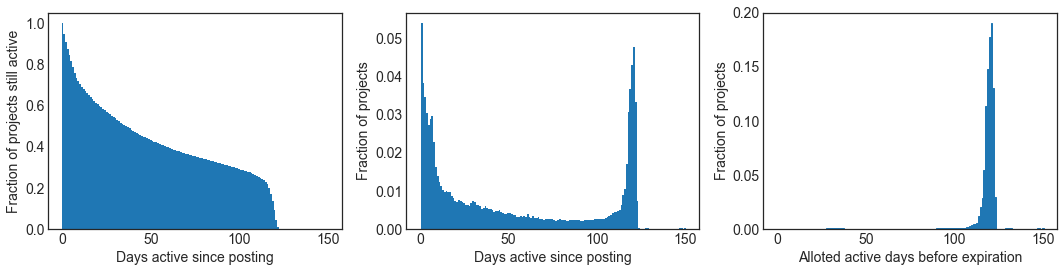

In [18]:
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,4))
xrange = np.arange(0,152,1)
hist, edges = np.histogram(finished_projects_df['Days Open'], bins = xrange, normed = True)
hist1, edges1 = np.histogram(finished_projects_df['Alloted Time'], bins = xrange, normed = True)

dx = edges[1] - edges[0]
edges = np.concatenate([[0], edges[:-1]])
cdf = np.concatenate([[0], np.cumsum(hist)*dx])

ax.bar(edges, 1-cdf, width = 1)
ax1.bar(edges1[:-1], hist, width = 1)
ax2.bar(edges1[:-1], hist1, width = 1, edgecolor = 'C0')

ax.set_xlabel('Days active since posting')
ax1.set_xlabel('Days active since posting')
ax2.set_xlabel('Alloted active days before expiration')

ax.set_ylabel('Fraction of projects still active')
ax1.set_ylabel('Fraction of projects')
ax2.set_ylabel('Fraction of projects')

fig.tight_layout()

In [19]:
proj_don_full = proj_don_full.merge(finished_projects_df[['Project ID', 'Alloted Time']], on = 'Project ID')
proj_don_full['Frac of alloted time elapsed'] = proj_don_full['Days Since Posting']/proj_don_full['Alloted Time']
proj_don_full['Frac of alloted time elapsed'] = proj_don_full['Frac of alloted time elapsed'].clip(upper = 1)

In [20]:
proj_don_full = proj_don_full.sort_values('Days Open').reset_index(drop = True)
proj_grps = proj_don_full.groupby('Project ID', sort = False)

In [21]:
mean_don_amount = proj_grps['Donation Amount'].mean().to_frame().reset_index()
finished_projects_df = finished_projects_df.merge(mean_don_amount, how = 'left')

### Plotting the cumulative donations over asking price for projects that are marked as 'Fully Funded' shows that some donations are missing from the dataset.
* This is due to DonorsChoose removing donations that were given by certain organizations that matched donations by employees from the dataset
* This means that all of the projects where the cummulative recorded donations equals the asking price are those that did not recieve any matched donations

In [22]:
max_cummulative_donations = pd.DataFrame(proj_grps['Cum Donations'].max().reset_index())
finished_projects_df = finished_projects_df.merge(max_cummulative_donations, on = 'Project ID')
ffunded = finished_projects_df['Project Current Status'] == 'Fully Funded'

count    675408.000000
mean          0.646612
std           0.297712
min           0.000030
25%           0.484592
50%           0.648128
75%           0.944885
max           2.550013
Name: Cum Don/Cost, dtype: float64

'Fully funded projects that likely have a organization matching donations: 573396'

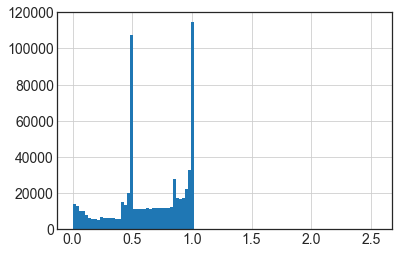

In [23]:
finished_projects_df['Cum Don/Cost'] = finished_projects_df['Cum Donations']/finished_projects_df['Project Cost']
display(finished_projects_df.loc[ffunded,'Cum Don/Cost'].hist(bins = 100))
display(finished_projects_df.loc[ffunded,'Cum Don/Cost'].describe())
'Fully funded projects that likely have a organization matching donations: '+ str(sum(finished_projects_df.loc[ffunded,'Cum Don/Cost']<1))

In [24]:
match = finished_projects_df['Cum Don/Cost'] < 1
finished_projects_df.loc[match&ffunded, 'Project Current Status'] = 'Fully Funded(match)'
proj_don_full = proj_don_full.merge(finished_projects_df[['Project ID', 'Project Current Status']], on = 'Project ID', how = 'left')
proj_don_full = proj_don_full.reset_index(drop = True)

In [26]:
edges = np.arange(0,1, 0.01)
hists = proj_don_full.groupby('Project ID', sort = False)['Frac of alloted time elapsed'].apply(lambda x: np.histogram(x, bins = edges)).to_frame()
hists = hists['Frac of alloted time elapsed'].apply(lambda x: x[0])
hists = hists.reset_index().rename(columns = {'Frac of alloted time elapsed':'Donation hist'})
finished_projects_df = finished_projects_df.merge(hists, on = 'Project ID', how = 'left')

In [ ]:
finished_projects_df = finished_projects_df.sort_values('Days Open')
grped_by_outcome = finished_projects_df.groupby('Project Current Status', sort = False)
grped_hists = grped_by_outcome['Donation hist'].apply(lambda x: np.vstack(x.values)).values
grped_costs = grped_by_outcome['Project Cost'].apply(lambda x: np.vstack(x.values)).values
grped_mean_don = grped_by_outcome['Donation Amount'].apply(lambda x: np.vstack(x.values)).values

In [51]:
def plot_rast_hist(hists,costs,mean_don, xlabel):
    ratio = np.array([hists[0].shape[0],hists[1].shape[0]])/hists[2].shape[0]
    fig, axes =  plt.subplots(4,3, figsize = (12,12), gridspec_kw = {'height_ratios':[ratio[0],ratio[1], 1, (ratio[1]+1)], 'width_ratios':[6,1,3]})
    axes[0,0].get_shared_x_axes().join(axes[0,0],axes[1,0],axes[2,0],axes[3,0])
    axes[0,1].get_shared_x_axes().join(axes[0,1],axes[1,1],axes[2,1],axes[3,1])
    axes[0,2].get_shared_x_axes().join(axes[0,2],axes[1,2],axes[2,2],axes[3,2])

    fig.subplots_adjust(wspace = 0.1)
    axes[3,1].axis('off')
    axes[3,2].axis('off')
    
    for n, ax,ax1,ax2,group,cost,don in zip([0,1,2],axes[:,0],axes[:,1],axes[:,2], hists, costs, mean_don):
        raster = ax.imshow(group, aspect = 'auto', vmax = 5, cmap = 'gist_heat_r')
        hist = np.sum(group, axis = 0)
        num_dons = np.convolve(np.sum(group, axis = 1), [1/1000]*1000, mode = 'same')
        ax1.plot(num_dons,np.arange(0,group.shape[0]))
        ax1.fill_betweenx(np.arange(0, len(num_dons),1), num_dons, color = 'C0', alpha = 0.5)
        cost = np.convolve(cost.ravel(), [1/1000]*1000, mode = 'same')
        ax2.plot(cost, np.arange(0, len(cost),1), color = 'C2', alpha = 0.2)
        ax2.fill_betweenx(np.arange(0, len(cost),1), cost, color = 'C2', alpha = 0.5)
        don = np.convolve(don.ravel(), [1/1000]*1000, mode = 'same')
        ax2.plot(don, np.arange(0, len(don),1), color = 'C2', alpha = 0.5)
        ax2.fill_betweenx(np.arange(0, len(don),1), don, color = 'C2', alpha = 0.5)
        
        ax1.set_ylim(len(num_dons), 0)
        if np.max(num_dons) > ax1.get_xlim()[1]:
            ax1.set_xlim(0, np.max(num_dons))
        if np.max(cost) > ax2.get_xlim()[1]:
            ax2.set_xlim(0, np.max(cost))
        ax2.set_xlim(0, 2000)

#         if n == 2:
# #             ax2.plot(num_dons*don, np.arange(0, len(don),1), color ='k')
        ax2.set_ylim(len(cost), 0)
        
        ax1.axes.get_yaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        [ax.spines[side].set_visible(False) for side in ['right', 'top']]
        [ax1.spines[side].set_visible(False) for side in ['right', 'top', 'left']]
        [ax2.spines[side].set_visible(False) for side in ['right', 'top', 'left']]

        axes[3,0].plot(hist/np.sum(hist))
        
    [axes[3, 0].spines[side].set_visible(False) for side in ['right', 'top']]
    axes[3, 0].set_xlim(0, 100)
    axes[3, 0].set_xlabel(xlabel)
    
    axes[0, 0].set_ylabel('Project num \n(fully fund. \nw match)')
    axes[1, 0].set_ylabel('Project num \n(fully fund. \nw/o match)')
    axes[2, 0].set_ylabel('Project num \n(expired)')
    axes[3, 0].set_ylabel('Fraction of \ndonations')
    axes[3, 0].text(0.5,0.7, 'Fully funded with match', color = 'C0', transform=axes[3, 0].transAxes)
    axes[3, 0].text(0.5,0.58, 'Fully funded without match', color = 'C1', transform=axes[3, 0].transAxes)
    axes[3, 0].text(0.5,0.46, 'Expired', color = 'C2', transform=axes[3, 0].transAxes)
    
    axes[0, 1].text(.9,0.85, 'Total number of citizen donations', color = 'C0', transform=axes[0, 1].transAxes, rotation = 270, va = 'top')
    axes[0, 2].text(.72,0.85, 'Average donation amount ($)', color = 'C2', transform=axes[0, 2].transAxes, rotation = 270, va = 'top')
    axes[0, 2].text(0.8,0.85, 'Project cost ($)', color = 'C2', alpha = 0.7, transform=axes[0, 2].transAxes, rotation = 270, va = 'top')

    cbaxes = fig.add_axes([.35, .85, 0.1, 0.01])  # This is the position for the colorbar
    cb = plt.colorbar(raster, cax = cbaxes, label = 'Number of citizen donations', orientation = 'horizontal')
    
    return fig

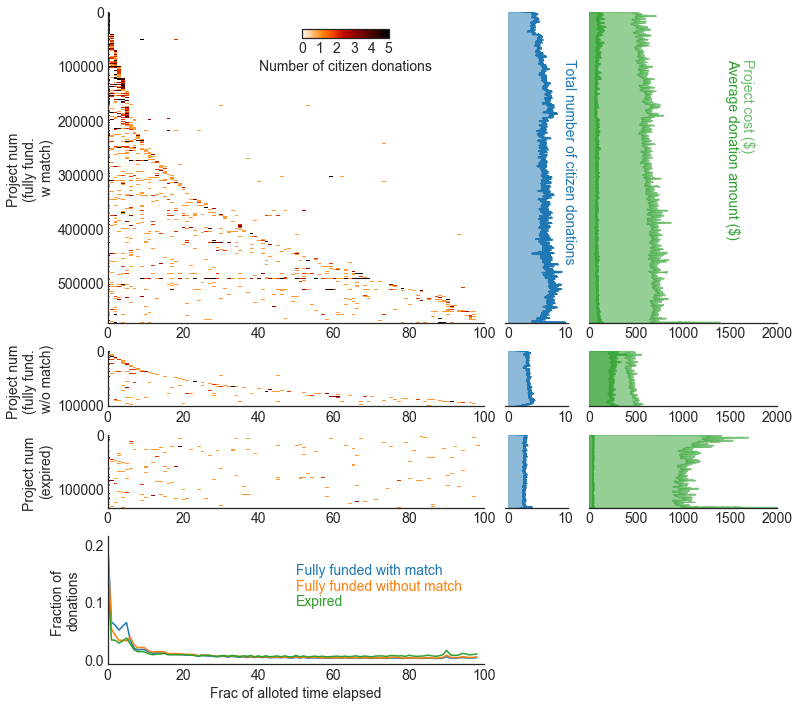

In [52]:
idx = [1,0,2]
fig = plot_rast_hist(grped_hists[idx], grped_costs[idx],grped_mean_don[idx], 'Frac of alloted time elapsed');

In [ ]:
fig.savefig('Donations.pdf', format = 'pdf')

In [ ]:
fig = plot_rast_hist(funded_hist_match, funded_hist_no_match, expired_hist,'Frac of alloted time elapsed');

In [ ]:
plot_rast_hist(funded_hist_match, funded_hist_no_match, expired ,'Frac of alloted time elapsed');

In [ ]:
proj_don_full[days_donated].sort_values(['Project ID', 'Date'])

In [ ]:
ratio = np.array([funded_hist_match.shape[0],funded_hist_no_match.shape[0]])/expired_hist.shape[0]
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (6,10), gridspec_kw = {'height_ratios':[ratio[0],ratio[1], 1, (ratio[1]+1)]}, sharex = True)
all_hists = np.vstack([funded_hist_match,funded_hist_no_match, expired_hist])

raster = ax1.imshow(funded_hist_match, aspect = 'auto', vmax = 5, cmap = 'gist_heat_r')
raster1 = ax2.imshow(funded_hist_no_match, aspect = 'auto', vmax = 5, cmap = 'gist_heat_r')
raster2 = ax3.imshow(expired_hist, aspect = 'auto', vmax = 5, cmap = 'gist_heat_r')

hist = np.sum(funded_hist_match, axis = 0)
hist1 = np.sum(funded_hist_no_match, axis = 0)
hist2 = np.sum(expired_hist, axis = 0)

ax4.plot(hist/np.sum(hist))
ax4.plot(hist1/np.sum(hist1))
ax4.plot(hist2/np.sum(hist2))

ax3.set_xlim(0, 100)
ax3.set_xlabel('Fraction elapsed active time')
for ax in [ax1,ax2,ax3,ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax1.set_ylabel('Project number \n(fully funded with match)')
ax2.set_ylabel('Project number \n(fully funded without match)')
ax3.set_ylabel('Project number \n(expired)')
ax3.set_ylabel('Fraction of donations')
ax4.text(0.7,0.7, 'Fully funded with match', color = 'C0', transform=ax4.transAxes)
ax4.text(0.7,0.60, 'Fully funded without match', color = 'C1', transform=ax4.transAxes)
ax4.text(0.7,0.50, 'Expired', color = 'C2', transform=ax4.transAxes)



In [ ]:
xrange = np.arange(0,1,0.025)
yrange = np.arange(0,1,0.025)

ffunded = proj_don_full['Project Current Status'].str.contains('Fully Funded')
exp = proj_don_full['Project Current Status'].str.contains('Expired')

hist_ffunded, xedges, yedges = np.histogram2d(proj_don_full.loc[days_donated&ffunded, 'Percent Completed'], 
                                      proj_don_full.loc[days_donated&ffunded, 'Frac of alloted time elapsed'], bins = (xrange,yrange), normed = True)

hist_exp, xedges, yedges = np.histogram2d(proj_don_full.loc[days_donated&exp, 'Percent Completed'], 
                                      proj_don_full.loc[days_donated&exp, 'Frac of alloted time elapsed'], bins = (xrange,yrange), normed = True)

hist_ffunded = hist_ffunded[::-1,:]
hist_exp = hist_exp[::-1,:]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
heatmap1 = ax1.imshow(hist_ffunded, extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect = 'auto', vmin = 0, cmap = 'inferno')
clim = heatmap1.get_clim()
heatmap2 = ax2.imshow(hist_exp, extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect = 'auto', vmin = 0, vmax = clim[1], cmap = 'inferno')

cbaxes = fig.add_axes([.95, 0.12, 0.03, 0.76])  # This is the position for the colorbar
cb = plt.colorbar(heatmap2, cax = cbaxes, label = 'Fraction of all donations')
ax1.set_xlabel('Fraction of alloted time elapsed');
ax1.set_ylabel('Fraction of funding already donated');

In [ ]:
proj_don_full['Frac of total price'] = proj_don_full['Donation Amount']/proj_don_full['Project Cost']
proj_don_full['Frac of total price'].hist(bins = 100)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,5))

for grp in ['Fully Funded', 'Expired']:
    ff_num_donations = num_donations.unstack()[grp]
    hist, edges = np.histogram(ff_num_donations[~ff_num_donations.isnull()], normed = True, bins = 250)
    dx = edges[1] - edges[0]
    edges = np.concatenate([[0], edges[:-1]])
    cdf = np.concatenate([[0], np.cumsum(hist)*dx])
    ax.plot(edges,cdf)
ax.set_xlim(0,30)
ax.set_ylim(0,1)

# Conclusions: 
* Reject initial hypothesis. There is no obvious relationship between 'duration the project has been active', 'fraction of requested price that has already beed donated', and 'likelyhood of donations'


* There seems to be two phases of funding relating to the duration that a project has been active: An initial burst of funding after posting that might be due to being more visible in search results. A second phase where funding is recieved at a much slower but generally constant rate


* Meanwhile, there is a relatively constant negative correlation between how much funding a project has already recieved and the probability of recieving a new donation
    * There are a few spikes in funding when projects are either halfway funded or close to being fully funded. This is may be due to DonorsChoose actively encouraging donations to projects that are nearing these milestones




# missing donation rows???
### Organizations would match donations made by individuals - these match donations were removed from donations table!
### this means that those projects that actually reach 100% funding in this dataset are those that did not receive any match donations
### can look at how fast those that do not recieve match donations and those that do get funded
### can also exclude projects that have match donations